<a href="https://colab.research.google.com/github/cloudy9982/restaurant-style-detect-/blob/main/%E3%80%8C%E9%A4%90%E5%BB%B3%E9%A2%A8%E6%A0%BC%EF%BC%A1%EF%BC%A9%E3%80%8Done_hot_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 讀入google drive並進入放置檔案的資料夾

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/餐廳AI') 

# 先下載斷詞套件
這邊我們使用的是ckiptagger，是繁體斷詞相對較好的套件，是中研院資訊所開發

其他最常被使用的套件有Stanford CoreNLP (simplified Chinese)

● Other popular ones:

○ LTP Cloud (simplified Chinese)

○ jieba (segmentation, both simplified/traditional
Chinese)

In [ ]:
!pip3 install ckiptagger
!pip3 install tensorflow
!pip3 install gdown
from ckiptagger import data_utils
data_utils.download_data_gdown("./")

Downloading...
From: https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
To: /content/drive/MyDrive/Colab Notebooks/餐廳AI/data.zip
100%|██████████| 1.88G/1.88G [00:13<00:00, 143MB/s]


# 把會用到的套件全部下載

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io
from ckiptagger import WS
from urllib.request import urlretrieve
import pickle
import re
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split

# x_train的資料前置準備

In [ ]:
restaurant_name = pd.read_excel('店家景點彙整.xlsx',usecols='A')
print('總共有：{}筆資料'.format(len(restaurant_name)))
restaurant_name.head()

總共有：2873筆資料


,restaurant
0,新竹吳家鴨香飯 (台南永康華興店)
1,早安牛肉湯美食館
2,楊記炒飯專賣店
3,阿紅魚肚湯鹹粥
4,川蜀滷味


##把用不到的特殊字元消除

In [ ]:
characters = "'!?()（） ,•[]【】。- —— / #的の"
txt_x = []
name_list = list(restaurant_name['restaurant'])
for content in name_list:
    for specialChar in characters:
      content = content.replace(specialChar, '')
    txt_x.append(content)
    print(content)

新竹吳家鴨香飯台南永康華興店
早安牛肉湯美食館
楊記炒飯專賣店
阿紅魚肚湯鹹粥
川蜀滷味
珍愛找茶
老溫小吃
上榮新疆烤肉串台南永康店
早菜單蔬食手作
狗啃玉米
日日十
易立低卡餐
陳記鴨肉麵
美式酥脆炸雞
兔子高帽雞蛋燒
日安Bonjour早餐
辣不唧ㄦ
億品鍋
燴廚燴飯專賣永康中華二店
頤真炸雞台南開元店
戰燒烤
八道晟台南永康中華店
皮咘咘早點
雞排本色台南成功店
聚會所熱炒燒烤
好ㄘ滷味
台南老張鹹酥雞
聚悅居義大利麵
大腸包小腸台南開元店
皇鼎御品鍋
窺雞福來得CrazyFriday台灣鹽酥雞
早美味美
柴與咖哩
豬血湯
京川鍋物
YUMMY蔥油餅台南成大店
洪城牛肉麵
飯島屋
奇美咖啡館
日光緩緩無毒早午餐台南東豐店
明太煮酸菜魚
找點
一鍋豔紅
中埔烤肉台南永康店
酒鬍子創意鍋燒
恐龍脆皮雞蛋糕
嘟嘟牛排台南永康店
御川香麻辣香鍋
阿明食堂台南中華店
茶米茶
Gpasta專業焗烤
Goodgee菇雞
黃家嫩骨飯
泰無國界料理
奧莉薇生活廚房
3爺臭臭鍋
米里mini永康華興店
廟口肉燥飯
蛤們鍋燒
北園東山鴨頭
幸運草小坊
THEYUAN台南東興店
港聚
敲之助鉄板焼き牛丼洋食
古根食堂鴨香飯
石橋子燒餅店
瑪奇甜甜圈
粟味齋蔬食
大夯牛排館台南育樂店
湖南牛肉麵店
大糖甜品台南東安店
享受牛排館
福來鱔魚意麵台南開元店
東寧烤肉
鳳記鹹酥雞
陳媽麵攤
金子半之助
自在軒台南東平店
烏咖蝦咖
早到晚到台南成大店
明洞海苔飯捲台南中華店
林家素食
盛來炒飯店
豬排專賣店
Q弟紅豆餅台南育樂店
成大館台南育樂店
九州豚骨拉麵台南育樂店
五木炭土司
梃記雞蛋糕
魔王狂爆雞排台南開元店
王廚活力廚房
來道黃燜雞米飯
邁滋味精緻早午餐
大上海鹹酥雞台南育樂店
甜圈圈台南淺草店
獨角康妮暮茶社
藏金安平貓小巴
小東路無名麵店竹滬麵店
潮洲宵夜
夏雪
Yes58義大利麵台南成大店
臭灶脚東寧店台北深坑清蒸麻辣臭豆腐
有時候手作杏仁甜湯
宵夜霸
粉味車輪餅台南勝利店
李記紅茶冰永康中華一店
香姑姑鹽酥雞
熱氣球雞蛋糕永康五王店
小董牛肉湯●爐
大大力牛排館
蔬食樂初始店SoothRoadOriginal
紅樓小館
哩賀雞蛋糕台南總店
楽飲Loving
玩真臭豆腐
文心圓手作蔬素食
DoubleCheese手工窯烤披薩
燕子吧雪燕窩桃膠.蓮子.銀耳
花福日式咖哩
沃野1

##斷詞(WS),返回的是一個 list。

In [ ]:
ws = WS("./data")
txts = []
for x in txt_x:
   txts.append(x)
ws_results = ws(txts)
ws_results

/usr/local/lib/python3.7/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:988: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  partitioner=maybe_partitioner)
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:996: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=initializer)


[['新竹', '吳家鴨', '香飯', '台南', '永康', '華興店'],
 ['早安', '牛肉湯', '美食館'],
 ['楊記', '炒飯', '專賣店'],
 ['阿紅', '魚肚湯', '鹹', '粥'],
 ['川蜀', '滷味'],
 ['珍愛', '找', '茶'],
 ['老', '溫', '小吃'],
 ['上榮', '新疆', '烤', '肉串', '台南', '永康店'],
 ['早菜', '單蔬', '食', '手作'],
 ['狗', '啃', '玉米'],
 ['日日', '十'],
 ['易', '立', '低卡餐'],
 ['陳記', '鴨肉麵'],
 ['美式', '酥脆', '炸雞'],
 ['兔子', '高帽', '雞蛋', '燒'],
 ['日安', 'Bonjour', '早餐'],
 ['辣', '不', '唧', 'ㄦ'],
 ['億品鍋'],
 ['燴廚', '燴飯', '專賣', '永康', '中華', '二店'],
 ['頤真', '炸雞', '台南', '開元店'],
 ['戰燒', '烤'],
 ['八', '道晟', '台南', '永康', '中華店'],
 ['皮', '咘咘', '早點'],
 ['雞排', '本色', '台南', '成功店'],
 ['聚會', '所', '熱', '炒', '燒', '烤'],
 ['好', 'ㄘ', '滷味'],
 ['台南', '老張', '鹹酥雞'],
 ['聚悅', '居', '義大利麵'],
 ['大腸包', '小腸', '台南', '開元店'],
 ['皇鼎', '御品鍋'],
 ['窺', '雞福', '來得', 'Crazy', 'Friday', '台灣', '鹽酥雞'],
 ['早', '美味', '美'],
 ['柴', '與', '咖哩'],
 ['豬血湯'],
 ['京川', '鍋物'],
 ['YUMMY', '蔥油餅', '台南', '成大店'],
 ['洪城', '牛肉麵'],
 ['飯島屋'],
 ['奇美', '咖啡館'],
 ['日光', '緩緩', '無', '毒', '早午餐', '台南', '東豐店'],
 ['明', '太', '煮', '酸菜魚'],
 ['找', '點'],
 ['一', '鍋', '豔紅'],


##文字轉成數據，這樣就完成這樣就完成x的資料前置處理

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(ws_results)
sequences = tokenizer.texts_to_sequences(ws_results)
sequences

[[250, 657, 658, 17, 212, 659],
 [159, 455, 213],
 [160, 10],
 [358, 44],
 [660, 6],
 [297, 42],
 [81, 37],
 [26, 17, 456],
 [82, 116],
 [661, 298],
 [],
 [662],
 [359],
 [63, 9],
 [663, 1],
 [664, 50],
 [251, 188],
 [665],
 [69, 212, 214, 666],
 [9, 17, 299],
 [26],
 [360, 17, 212, 55],
 [252],
 [78, 667, 17, 300],
 [189, 161, 12, 1, 26],
 [45, 6],
 [17, 83],
 [301, 162],
 [668, 669, 17, 299],
 [],
 [670, 671, 672, 673, 674, 64, 141],
 [46, 302, 70],
 [303, 43],
 [],
 [73],
 [117, 17, 457],
 [20],
 [],
 [],
 [142, 21, 17],
 [675, 253, 143, 676],
 [297, 361],
 [16, 118],
 [304, 17, 456],
 [677, 1],
 [458, 254, 31],
 [459, 34, 17, 456],
 [678],
 [18, 17, 55],
 [],
 [190, 679],
 [],
 [680],
 [305, 142, 2],
 [681, 27],
 [682, 88],
 [212, 659],
 [683, 684],
 [191],
 [192, 163],
 [685, 460],
 [17, 686],
 [687, 461],
 [688, 362],
 [18],
 [],
 [193],
 [89],
 [14, 462, 215, 17, 306],
 [463, 119, 84],
 [14, 464, 216, 17],
 [215],
 [465, 363, 17, 299],
 [26, 307],
 [83],
 [689],
 [466, 97],
 [46

把數據放進把數據放進x

In [ ]:
x = sequences

# y_train的資料前置準備

In [ ]:
restaurant_style = pd.read_excel('店家景點彙整.xlsx',usecols='G')
print(len(restaurant_style))
restaurant_style.head()

2873


,style
0,中式
1,中式
2,中式
3,中式
4,中式


##style_list是個是個list

有以下種類的餐廳風格

In [ ]:
set(restaurant_style['style'])

{'中式',
 '印尼',
 '印度',
 '台式',
 '日式',
 '歐式',
 '法式',
 '泰式',
 '港式',
 '澳式',
 '美式',
 '義式',
 '越式',
 '韓式',
 '馬來西亞'}

## 文字轉成數據，這樣就完成這樣就完成y的資料前置處理

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
sequences = onehotencoder.fit_transform(restaurant_style).toarray()
sequences

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

下方為onehotencodeing各個index所代表的意義

In [ ]:
print(   onehotencoder.inverse_transform([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
      onehotencoder.inverse_transform([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]))

[['中式']] [['印尼']] [['印度']] [['台式']] [['日式']] [['歐式']] [['法式']] [['泰式']] [['港式']] [['澳式']] [['美式']] [['義式']] [['越式']] [['韓式']] [['馬來西亞']]


把數據放進把數據放進y

In [ ]:
y = sequences

# 資料處理



資料量：

x_train,y_train 20%

x_test,y_test 80%

random_state=87 隨機產生一種狀況（亂數種子）

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=87)

資料長度不一樣對計算上有麻煩, 要固定一定長度, 其餘補 0

我更改最長長度為20，因為餐廳名稱通常不超過20個字

In [ ]:
x_train = sequence.pad_sequences(x_train, maxlen=20)
x_test = sequence.pad_sequences(x_test, maxlen=20)

### 打造一個函數學習機

In [ ]:
model = Sequential()

batch = 32，更改batch維度

In [ ]:
model.add(Embedding(1000,64))

LSTM的神經元改成32，返回維度為32的向量序列

In [ ]:
model.add(LSTM(32))

10個神經元(風格)

In [ ]:
model.add(Dense(15, activation='softmax'))

#### 我們的 model

#### 組裝

In [ ]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 15)                495       
                                                                 
Total params: 76,911
Trainable params: 76,911
Non-trainable params: 0
_________________________________________________________________


### 訓練

array 和 asarray 都可以將 結構資料 轉化為 ndarray，但是主要區別就是當資料來源是ndarray時，array仍然會copy出一個副本，佔用新的記憶體，但asarray不會。

把格式全改成numpy.ndarray，以免有錯誤型態

In [ ]:
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

訓練次數我改成十次，validation_data是把測試資料也拿來是把測試資料也拿來fit，讓預測更準確，batch_size改成300，訓練次數過多會過度訓練，會讓機器全猜最高的那項

In [ ]:
history = model.fit(x_train, y_train, batch_size=300, epochs=10,validation_data=(x_test, y_test))

Epoch 1/10
8/8 [==============================] - 4s 165ms/step - loss: 2.6621 - accuracy: 0.5117 - val_loss: 2.5711 - val_accuracy: 0.7757
Epoch 2/10
8/8 [==============================] - 0s 43ms/step - loss: 2.4589 - accuracy: 0.7903 - val_loss: 2.2333 - val_accuracy: 0.7757
Epoch 3/10
8/8 [==============================] - 0s 48ms/step - loss: 1.9128 - accuracy: 0.7903 - val_loss: 1.4250 - val_accuracy: 0.7757
Epoch 4/10
8/8 [==============================] - 0s 52ms/step - loss: 1.2026 - accuracy: 0.7903 - val_loss: 1.0709 - val_accuracy: 0.7757
Epoch 5/10
8/8 [==============================] - 0s 50ms/step - loss: 1.0156 - accuracy: 0.7903 - val_loss: 1.0040 - val_accuracy: 0.7757
Epoch 6/10
8/8 [==============================] - 0s 50ms/step - loss: 0.9635 - accuracy: 0.7903 - val_loss: 0.9727 - val_accuracy: 0.7757
Epoch 7/10
8/8 [==============================] - 0s 52ms/step - loss: 0.9354 - accuracy: 0.7903 - val_loss: 0.9469 - val_accuracy: 0.7757
Epoch 8/10
8/8 [==========

### 測試

把準確度和loss畫成圖表示

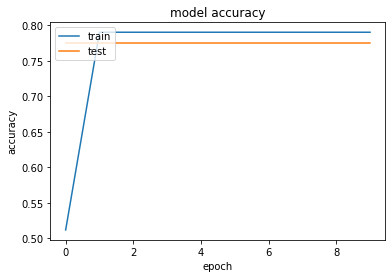

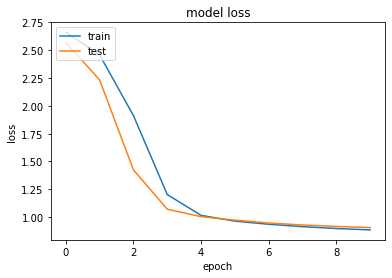

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

用gradio來讓大家互動

In [ ]:
!pip install gradio
import gradio as gr

In [ ]:
label = ['中式','印尼','印度','台式','日式','歐式','法式','泰式','港式','澳式','美式','義式','越式','韓式','馬來西亞']

In [ ]:
def pred(name):
  tokenizer.fit_on_texts(name)
  output = tokenizer.texts_to_sequences(name)
  out = np.argmax(model.predict(output)[0])
  result = label[out]
  return result

In [ ]:
gr.Interface(fn=pred, inputs="text", outputs="label").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://26059.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7862/',
 'https://26059.gradio.app')

#困難

In [ ]:
lists = np.empty(20);
for style in list(restaurant_style['style']):
  if(style=="中式"):
    lists[0] = lists[0]+1
  if(style=="印尼"):
    lists[1] = lists[1]+1
  if(style=="印度餐廳"):
    lists[2] = lists[2]+1
  if(style=="台式"):
    lists[3] = lists[3]+1
  if(style=="日式"):
    lists[4] = lists[4]+1
  if(style=="歐式"):
    lists[5] = lists[5]+1
  if(style=="法式"):
    lists[6] = lists[6]+1
  if(style=="泰式"):
    lists[7] = lists[7]+1
  if(style=="港式"):
    lists[8] = lists[8]+1
  if(style=="澳式"):
    lists[9] = lists[9]+1
  if(style=="美式"):
    lists[10] = lists[10]+1
  if(style=="義式"):
    lists[11] = lists[11]+1
  if(style=="越式"):
    lists[12] = lists[12]+1
  if(style=="韓式"):
    lists[13] = lists[13]+1
  if(style=="馬來西亞"): 
    lists[14] = lists[14]+1 

In [ ]:

j=0
for i in lists:
  print(label[j],' ：',round(i))
  j=j+1

中式  ： 2331
印尼  ： 234
印度  ： 103
台式  ： 197
日式  ： 402
歐式  ： 107
法式  ： 176
泰式  ： 113
港式  ： 244
澳式  ： 60
美式  ： 324
義式  ： 139
越式  ： 285
韓式  ： 116
馬來西亞  ： 307


IndexError: ignored

因為輸入的輸入的data太過於偏向某一風格，所以變成所以變成model大部分都會猜同一種，關於這方面的解決方式我們認為從資料去著手，我們認為從資料去著手，model訓練時可以平衡一下輸入的data